# Generate Perlin noise functions

In [14]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

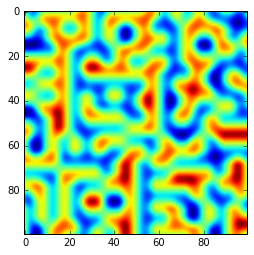

In [110]:
def perlin(x,y,seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u)
    return lerp(x1,x2,v) + 1e-15 # avoid zero

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y

lin = np.linspace(0,10,100,endpoint=False)
x,y = np.meshgrid(lin,lin)

plt.imshow(perlin(x,y,seed=2),origin='upper')

In [432]:
def per_freq(freq=1):
    lin = np.linspace(0,50/freq,100,endpoint=False)
    x,y = np.meshgrid(lin,lin)
    return perlin(x,y,seed=2)

#### Large scale

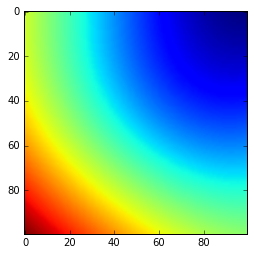

In [443]:
plt.imshow(per_freq(freq=128))

### make a composite...

In [429]:
#per_sum_test = (per_freq(2)+per_freq(5)+per_freq(8)+per_freq(16))/3
per_sum_test = per_freq(4) + per_freq(8)

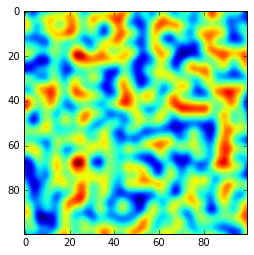

In [430]:
plt.imshow(per_sum_test,origin='upper')

### Curl-noise (using stream function)
_See Bridson+[2007](http://doi.acm.org/10.1145/1275808.1276435)_

In [169]:
def grad(freq=1,eps=1e-4,seed=1240):
    """
    The one true way of computing gradients (curl-noise) ! Do NOT use np.gradient!
    """
    lin = np.linspace(0,10/freq,100)
    x,y = np.meshgrid(lin,lin)
    
    stream = perlin(x,y,seed=seed)
    rot_gx =  (perlin(x,y+eps,seed=seed) - perlin(x,y-eps,seed=seed)) / 2
    rot_gy = -(perlin(x+eps,y,seed=seed) - perlin(x-eps,y,seed=seed)) / 2
    
    return stream, (rot_gx,rot_gy)

In [170]:
ss,(rx,ry) = grad(freq=1)

In [ ]:
## normalization (to unit length)
rxn,ryn = rx/np.sqrt(rx**2+ry**2),ry/np.sqrt(rx**2+ry**2)

#### Curl-noise

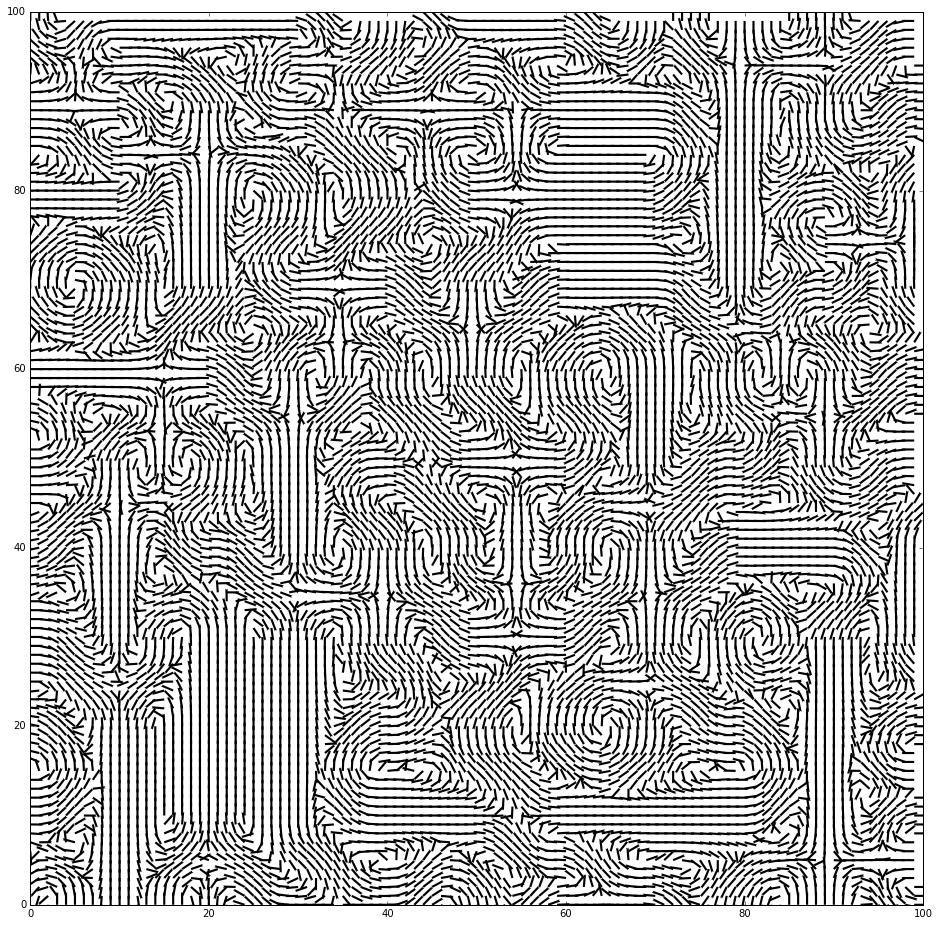

In [174]:
plt.figure(figsize=(16,16))
X,Y = np.meshgrid(np.arange(rxn.shape[0]),np.arange(ryn.shape[1]))
plt.quiver(X,Y,rxn,ryn,scale=40,headwidth=0)

#### Gradient noise (= curl noise rotated by -90 deg)

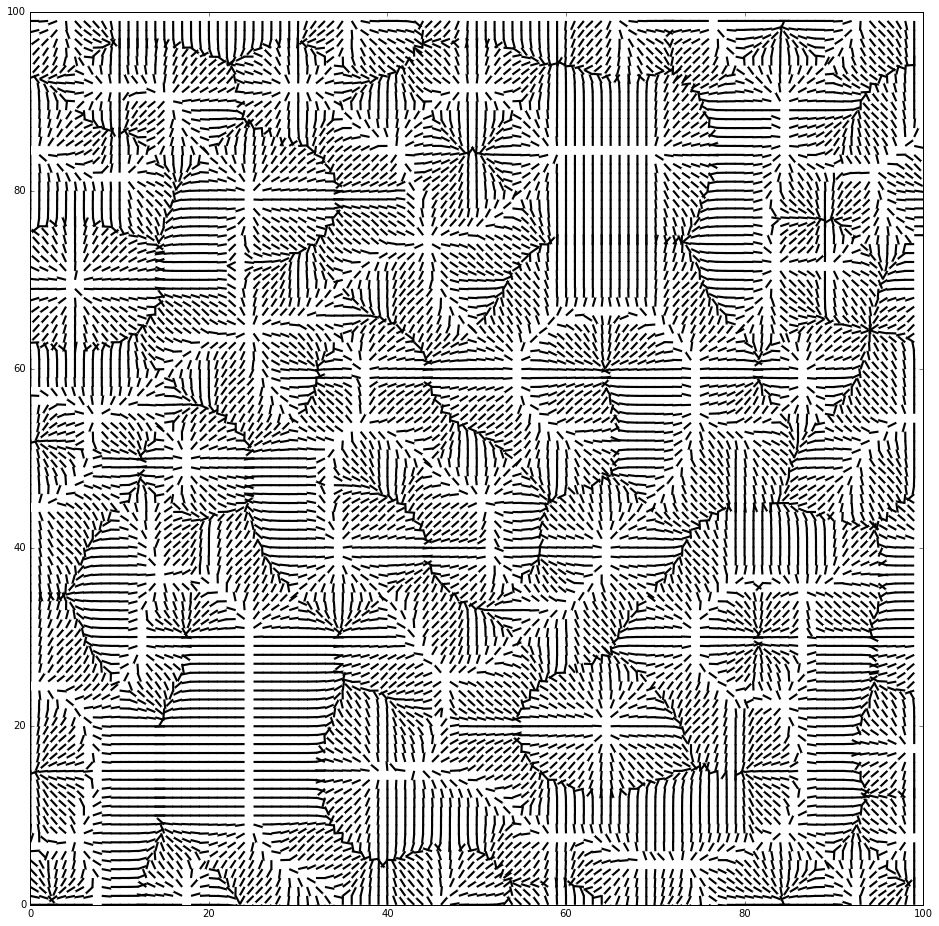

In [148]:
## compressive
plt.figure(figsize=(16,16))
X,Y = np.meshgrid(np.arange(rxn.shape[0]),np.arange(ryn.shape[1]))
plt.quiver(X,Y,-ryn,rxn,scale=45,headwidth=0)

---
## Numerical proof of E/B equivalence
for 2D directionless curl/gradient-noises<br>
_See the project paper Appendix_

In [178]:
psi = np.mod(np.arctan2(ryn,rxn),np.pi)
Q = np.cos(2*psi)
U = np.sin(2*psi)

qf = np.fft.fft2(Q)
uf = np.fft.fft2(U)
    
## frequencies
fq_x,fq_y = np.meshgrid(np.fft.fftfreq(qf.shape[0]),np.fft.fftfreq(qf.shape[1]))
fu_x,fu_y = np.meshgrid(np.fft.fftfreq(uf.shape[0]),np.fft.fftfreq(uf.shape[1]))

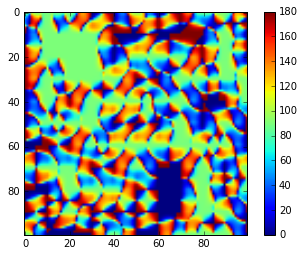

In [179]:
plt.imshow(np.rad2deg(psi))
plt.colorbar()

#### curl-noise

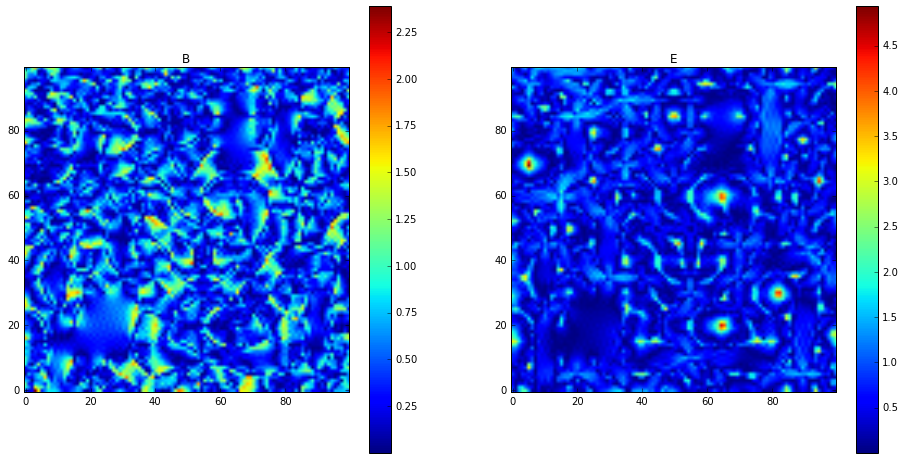

In [422]:
## Magnitude of the modes
plt.figure(figsize=(16,8))
plt.subplot(121)
X,Y = np.meshgrid(np.arange(rot_E.shape[0]),np.arange(rot_E.shape[1]))
#plt.quiver(X,Y,np.cos(rot_B),np.sin(rot_B),scale=40,headwidth=0)
plt.imshow(np.abs(rot_B), origin='lower')
plt.title('B'); plt.colorbar()

plt.subplot(122)
X,Y = np.meshgrid(np.arange(rot_E.shape[0]),np.arange(rot_E.shape[1]))
#plt.quiver(X,Y,np.cos(rot_E),np.sin(rot_E),scale=40,headwidth=0)
plt.imshow(np.abs(rot_E), origin='lower')
plt.title('E'); plt.colorbar()

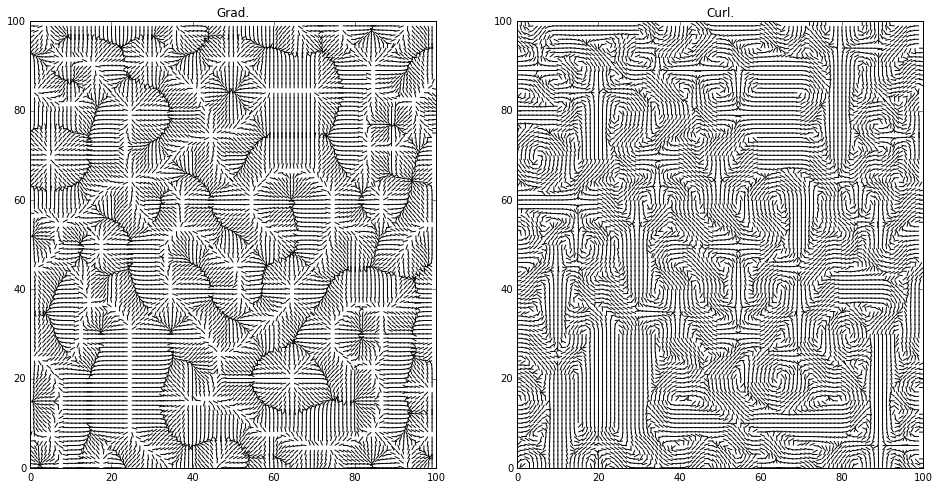

In [204]:
plt.figure(figsize=(16,8))
plt.subplot(121)
X,Y = np.meshgrid(np.arange(rot_E.shape[0]),np.arange(rot_E.shape[1]))
plt.quiver(X,Y,-ryn,rxn,scale=40,headwidth=0)
plt.title('Grad.')

plt.subplot(122)
X,Y = np.meshgrid(np.arange(rot_E.shape[0]),np.arange(rot_E.shape[1]))
plt.quiver(X,Y,rxn,ryn,scale=40,headwidth=0)
plt.title('Curl.')

#### gradient noise

In [202]:
gra_E, gra_B = HHD(-ryn,rxn)

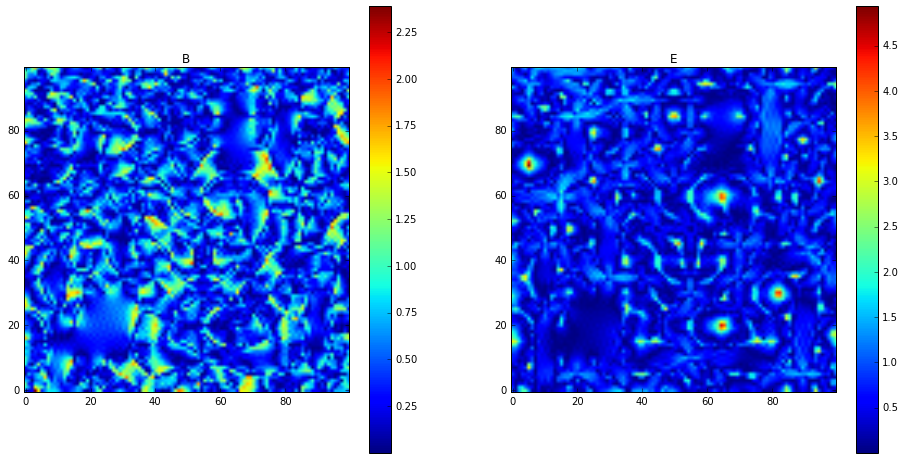

In [203]:
## Magnitude of the modes
plt.figure(figsize=(16,8))
plt.subplot(121)
X,Y = np.meshgrid(np.arange(gra_E.shape[0]),np.arange(gra_E.shape[1]))
plt.imshow(np.abs(gra_B), origin='lower')
plt.title('B'); plt.colorbar()

plt.subplot(122)
X,Y = np.meshgrid(np.arange(gra_E.shape[0]),np.arange(gra_E.shape[1]))
plt.imshow(np.abs(gra_E), origin='lower')
plt.title('E'); plt.colorbar()

#### Examing the Q U
proving that Qr=-Qg / Ur=-Ug

In [214]:
psi = np.arctan2(ryn,rxn)
    
Qr = np.cos(2*psi)
Ur = np.sin(2*psi)

psi = np.arctan2(rxn,-ryn)
    
Qg = np.cos(2*psi)
Ug = np.sin(2*psi)

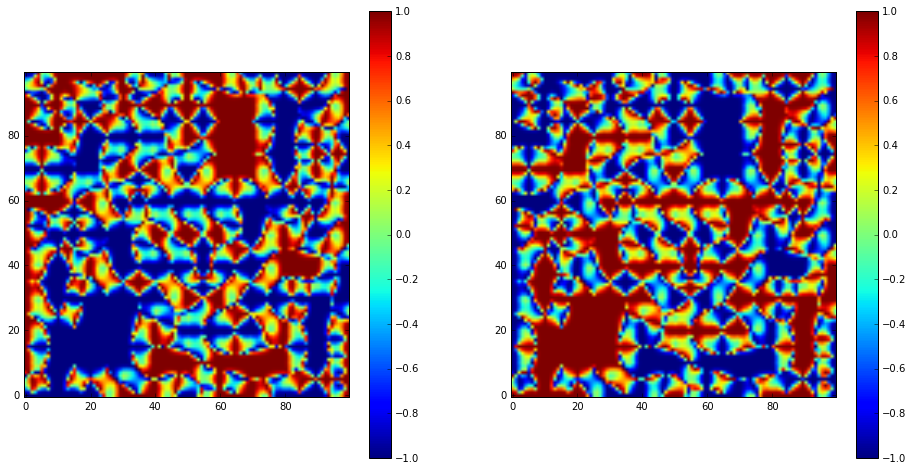

In [215]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(Qr,origin="lower"); plt.colorbar()
plt.subplot(122)
plt.imshow(Qg,origin="lower"); plt.colorbar()

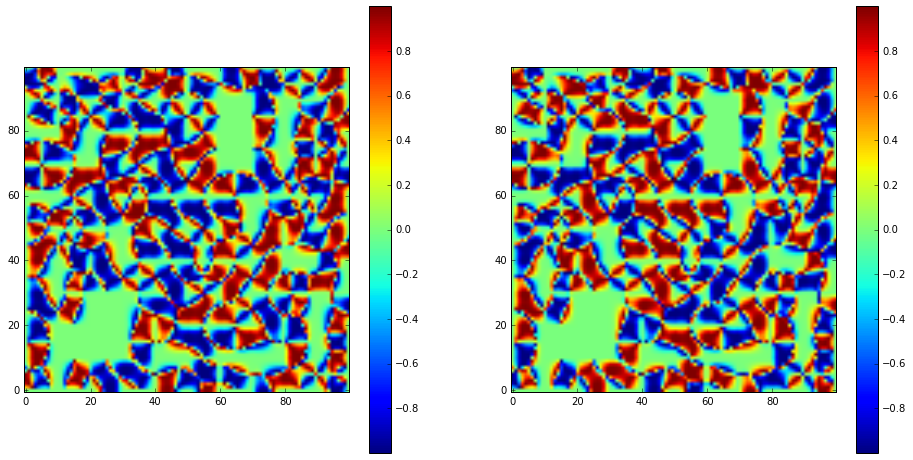

In [216]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(Ur,origin="lower"); plt.colorbar()
plt.subplot(122)
plt.imshow(Ug,origin="lower"); plt.colorbar()

## Sanity check: 
transforming -> inverse trans. produces the original field<br>
_Algorithm from QU to EB: Louis+[2013](http://dx.doi.org/10.1093/mnras/stt1421). This is just the inverse_

In [415]:
### Given pure B, or E, or mix, what does the field look like?!
def EB_to_vec(B,E):
    bf = np.fft.fft2(B)
    ef = np.fft.fft2(E)
    
    #####
    fq_x,fq_y = np.meshgrid(np.fft.fftfreq(ef.shape[1]),np.fft.fftfreq(ef.shape[0]))
    phi_l = np.mod(np.arctan2(fq_y,fq_x),np.pi) 
    phi_c = 2 * phi_l
    
    qf = ef * np.cos(phi_c) - bf * np.sin(phi_c)
    uf = ef * np.sin(phi_c) + bf * np.cos(phi_c)
    
    #####    
    Q, U = np.real(np.fft.ifft2(qf)), np.real(np.fft.ifft2(uf))
    
    pa = np.mod(0.5 * np.arctan2(U,Q),np.pi)
    
    xx, yy = np.cos(pa), np.sin(pa)
    
    return pa, (xx, yy)

#### Let's put in the curl-noise and transform -> inverse transform it

In [395]:
#papb,(xxpb,yypb) = EB_to_vec(pur_b,pur_be)
papb,(xxpb,yypb) = EB_to_vec(rot_B,rot_E)

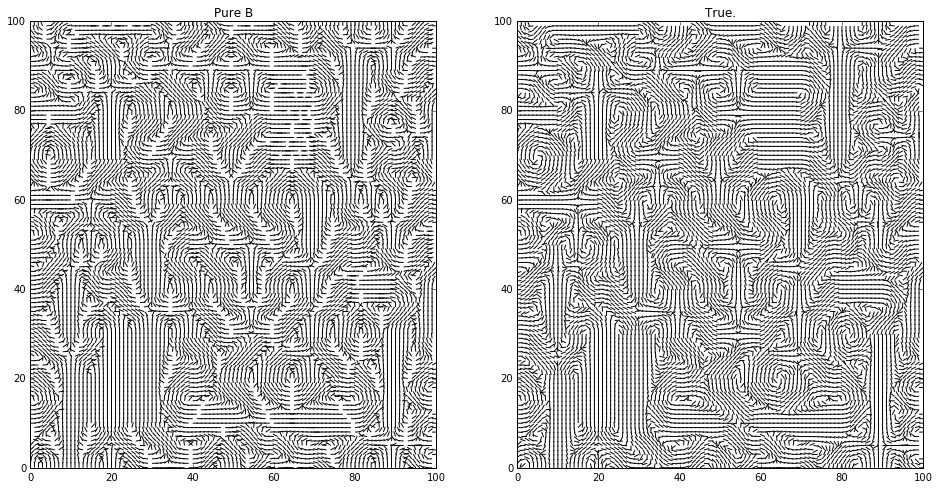

In [398]:
plt.figure(figsize=(16,8))
plt.subplot(121)
X,Y = np.meshgrid(np.arange(papb.shape[0]),np.arange(papb.shape[1]))
plt.quiver(X,Y,xxpb,yypb,scale=40,headwidth=0)
plt.title('Pure B')

plt.subplot(122)
X,Y = np.meshgrid(np.arange(rot_E.shape[0]),np.arange(rot_E.shape[1]))
plt.quiver(X,Y,rxn,ryn,scale=40,headwidth=0)
plt.title('True.')

OKay.

In [405]:
B = np.ones((100,100)) + np.random.random((100,100))*1e-3
E = np.random.random((100,100)) * 1e-3 ## dominating B-mode

B_ = np.random.random((100,100))* 1e-3 ## dominating E-mode
E_ = np.ones((100,100)) + np.random.random((100,100))* 1e-3

In [406]:
pa,(xx,yy) = EB_to_vec(B,E)
pa_,(xx_,yy_) = EB_to_vec(B_,E_)

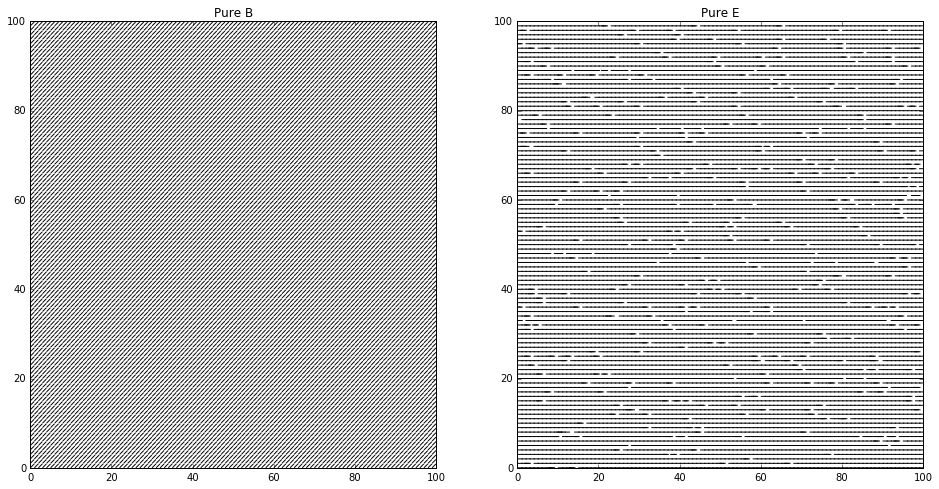

In [407]:
plt.figure(figsize=(16,8))
plt.subplot(121)
X,Y = np.meshgrid(np.arange(B.shape[0]),np.arange(B.shape[1]))
plt.quiver(X,Y,xx,yy,scale=40,headwidth=0)
plt.title('Pure B')

plt.subplot(122)
X,Y = np.meshgrid(np.arange(B.shape[0]),np.arange(B.shape[1]))
plt.quiver(X,Y,xx_,yy_,scale=40,headwidth=0)
plt.title('Pure E')

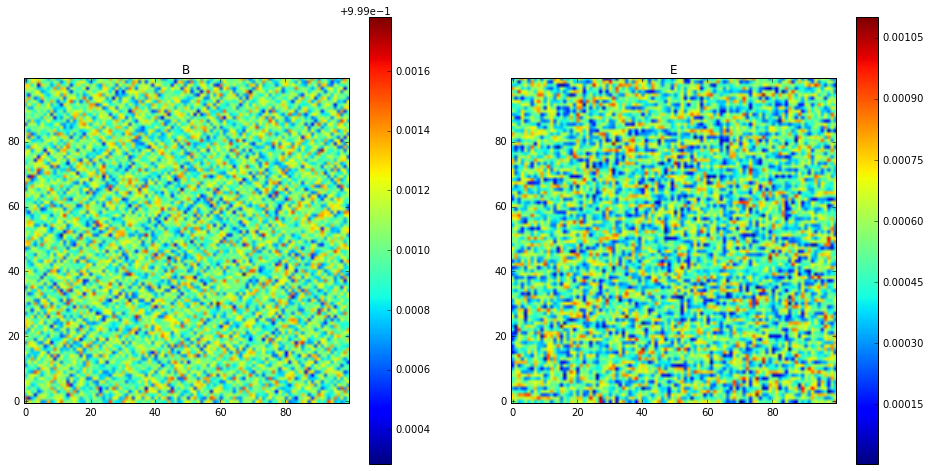

In [413]:
## Magnitude of the modes
plt.figure(figsize=(16,8))
plt.subplot(121)
X,Y = np.meshgrid(np.arange(pur_b.shape[0]),np.arange(pur_b.shape[1]))
plt.imshow(np.abs(pur_b), origin='lower')
plt.title('B'); plt.colorbar()

plt.subplot(122)
X,Y = np.meshgrid(np.arange(pur_b.shape[0]),np.arange(pur_b.shape[1]))
plt.imshow(np.abs(pur_be), origin='lower')
plt.title('E'); plt.colorbar()

proved that my code is working!!!! hooray~~~